# Earliest Deadline First Charging Strategy

In [2]:
import numpy as np
import csv
import cvxpy as cp #convex optimization
import matplotlib.pyplot as plt 
import argparse
import time

arrival time:25.0


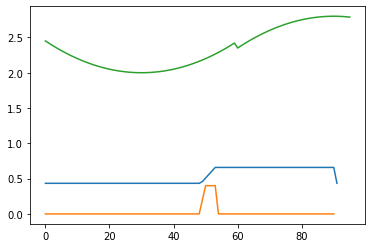

the energy delivery: 160.22, the required energy: 194.73, the carbon emission term: 356.08


In [4]:
num_steps = 96
total_vehicles = 50
battery_capacity = 8
power_capacity = 3
max_power_u = 0.4

dataset = generate_dataset(num_step=num_steps, total_vehicles=total_vehicles, battery_capacity=battery_capacity)
carbon_intensity = dataset['carbon_intensity']
arrival_time = dataset['arrival_time']
depart_time = dataset['depart_time']
initial_state = dataset['initial_state']
final_energy = dataset['final_energy']
required_energy = dataset['required_energy']

x, u = EDF_charging(carbon_intensity, total_vehicles, num_steps, initial_state, max_power_u, final_energy, arrival_time, depart_time, power_capacity, battery_capacity)
carbon_emission = np.sum(np.array([u[:,t]*carbon_intensity[t] for t in range(num_steps)]))
print(f'the energy delivery: {round(np.sum(u),2)}, the required energy: {round(np.sum(required_energy),2)}, the carbon emission term: {round(carbon_emission,2)}')

In [3]:
def generate_dataset(num_step=96, total_vehicles=100, battery_capacity = 8, lam=9, seed=0):
    np.random.seed(seed)
    arrival_time= np.random.poisson(lam=lam, size=(total_vehicles,))
    arrival_time = np.sort(arrival_time)*4.0
    arrival_time = arrival_time + np.random.randint(0,4, size=(total_vehicles,))
    arrival_time = np.sort(arrival_time)
    depart_time = np.random.randint(6, 36, size=(total_vehicles,))
    depart_time = np.min((arrival_time+depart_time, np.ones_like(arrival_time)*num_step), axis=0)
    
    initial_state=np.random.uniform(0.8, 4.0, size=(total_vehicles,))
    required_energy=np.random.uniform(2.0, 6.0, size=(total_vehicles,))
    final_energy = np.min((initial_state+required_energy, np.ones_like(initial_state)*battery_capacity), axis=0)
    required_energy = np.round(final_energy-initial_state, 2)
    
    carbon_intensity = np.array([0.005*(t-30)**2 + 20 for t in range(60)] + [-0.005*(t-30)**2 + 28 for t in range(36)]) / 10
    dataset = {'carbon_intensity':carbon_intensity, 'arrival_time':arrival_time, 'depart_time':depart_time, 'initial_state':initial_state, 'required_energy': required_energy, 'final_energy':final_energy}
    
    return dataset

def EDF_charging(carbon_intensity, num_of_vehicles, timesteps, initial_states, max_power, terminal_states, arrival_time, dept_time, power_capacity, B):
    initial_state_EDF = np.copy(initial_states)
    all_state_EDF = np.zeros((num_of_vehicles, timesteps+1))
    for t in range(timesteps):
        all_state_EDF[:,t] = initial_state_EDF[:]
    u_mat=np.zeros((num_of_vehicles, timesteps), dtype=float)
    sum_delivery = 0.

    #-5 to avoid computation infeasibility at this time
    for t in range(int(arrival_time[0])+1, num_steps-5):
        power_budget=power_capacity #Change this for variable case

        #print("Current time", t)

        #Firstly get the states
        #print("current number of arrived cars", (arrival_time < t).sum())
        vehicle_ending_index = (arrival_time < t).sum()
        step_initial_SOC = np.copy(initial_state_EDF[:vehicle_ending_index])
        depart_schedule=np.copy(depart_time[:vehicle_ending_index])
        u_val=np.zeros_like(step_initial_SOC) #record available cars charging rate
        index=np.argsort(depart_schedule) #sort the departure time
        charging_sessions=0

        while power_budget>=0:
            if depart_schedule[index[charging_sessions]] >= t: #not departed yet
                available_charging=np.minimum(max_power, power_budget)
                u_val[index[charging_sessions]] = np.maximum(np.minimum(available_charging, final_energy[index[charging_sessions]]-step_initial_SOC[index[charging_sessions]]),0)

            power_budget -= u_val[index[charging_sessions]]
            charging_sessions+=1

            if charging_sessions>=vehicle_ending_index:
                break

        #print("SUM EDF", np.sum(u_val))
        updated_val = u_val
        #print("U after MPC cut", updated_val)
        #print("SUM EDF Cut", np.sum(updated_val))
        initial_state_EDF[:vehicle_ending_index] += updated_val
        #print("SOC_states", np.round(initial_state_SOC[:vehicle_ending_index],2))
        u_mat[:vehicle_ending_index, t]=updated_val
        all_state_EDF[:,t] = initial_state_EDF[:]

    plt.plot(all_state_EDF[10,:-5]/B,label='SoC')
    plt.plot(u_mat[10,:-5],label='charging_power')
    plt.plot(carbon_intensity,label='carbon_intensity')
    print(f'arrival time:{arrival_time[10]}')
    plt.show()
    
    return all_state_EDF/B, u_mat